In [ ]:
!pip install -q scikit-learn==1.0.1

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, cohen_kappa_score, make_scorer
import itertools
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import random
from typing import Dict, List

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Quadratic Weighted Kappa

The below explanation will correspond to my [notebook during the PANDAS competition](https://www.kaggle.com/reighns/understanding-the-quadratic-weighted-kappa/).

 ## Table of Contents
1. [Intuition of QWK](#intuition)
2. [Step 1: Create the NxN histogram matrix O](#confusion) <br>
3. [Step 2: Create the Weighted Matrix w](#weighted)<br>
4. [Step 3: Create the Expected Matrix](#expected) <br>
5. [Step 4: Final Step: Weighted Kappa formula and Its python codes](#qwk) 

    

## **Intuition of QWK** <a id="intuition"></a> <a id="intuition"></a>

TLDR: one can skip to the last section on the python code implementation of QWK and also take reference to [CPMP's Fast QWK Computation](https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/145105) as well.

Kappa or Cohen’s Kappa is like classification accuracy, except that it is normalized at the baseline of random chance on your dataset: It basically tells you how much better your classifier is performing over the performance of a classifier that simply guesses at random according to the frequency of each class.

First off, we define the formula exactly as mentioned. Quoting from the evaluation page: **Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.** 

**The quadratic weighted kappa is calculated as follows. First, an N x N histogram matrix O is constructed, such that $O_{i,j}$ corresponds to the number of `isup_grade`'s i (actual) that received a predicted value j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted values:**

$$w_{i,j} = \dfrac{(i-j)^2}{(N-1)^2}$$

<br>

**An N-by-N histogram matrix of expected outcomes, E, is calculated assuming that there is** ***no correlation*** **between values.This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that E and O have the same sum. **

<br>

Finally, from these three matrices, the quadratic weighted kappa is calculated as:


$$\kappa = 1 - \dfrac{\sum_{i,j}\text{w}_{i,j}O_{i,j}}{\sum_{i,j}\text{w}_{i,j}E_{i,j}}$$

where $w$ is the weighted matrix, $O$ is the histogram matrix and $E$ being the expected matrix.

## **Step 1: Create the NxN histogram matrix O** <a id="confusion"></a>

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

***Warning: This is a counter example to the wrong usage of Quadratic Weighted Kappa. We shall see why soon.***

<br>

***Reminder: Although it is a counter example, it still illustrates what a NxN histogram matrix is! We will now call our histogram matrix C instead because in actual fact, the histogram matrix is merely a multi class confusion matrix between actual and predicted values***

We use a naive example where there are 5 classes (note our competition is_up grade has 6 classes; but this is just an example. Our `y_true` is the ground truth labels and correspondingly, our `y_pred` is the predicted values.

In [ ]:
y_true = pd.Series(['cat',  'cat', 'dog', 'cat',   'cat',  'cat', 'pig',  'pig', 'hen', 'pig'], name = 'Actual')
y_pred   = pd.Series(['bird', 'hen', 'pig','bird',  'bird', 'bird', 'pig', 'pig', 'hen', 'pig'], name = 'Predicted')

print("Ground truth:\n{}".format(y_true))
print("-"*40)
print("Predicted Values:\n{}".format(y_pred))

Ground truth:
0    cat
1    cat
2    dog
3    cat
4    cat
5    cat
6    pig
7    pig
8    hen
9    pig
Name: Actual, dtype: object
----------------------------------------
Predicted Values:
0    bird
1     hen
2     pig
3    bird
4    bird
5    bird
6     pig
7     pig
8     hen
9     pig
Name: Predicted, dtype: object


First, an N x N confusion matrix **C** is constructed, such that $\text{C}_{i,j}$ is the entry that corresponds to the **number of animal i (actual) that received a predicted value j**. 

<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


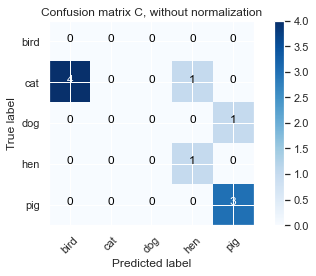

In [ ]:
classes= ['bird','cat','dog','hen', 'pig']

# thank you https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_true, y_pred,labels=['bird','cat','dog','hen', 'pig'],)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['bird','cat','dog','hen', 'pig'],
                      title='Confusion matrix C, without normalization')

### Example using our competition's dataset

The above matrix is a **multi class confusion matrix**. As an example, for the 2nd row, we predicted 4 cats to be birds, and 1 cat to be predicted as hen. More compactly, it can be represented as the matrix $C_{2,1}$ = 4.

We can easily reconcile our example above to relate back to our competition: **After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale**. For now, I will include the label **0** because it is the background/non-tissue. 

What I do next is to take the ground truth and call it `y_true` which is a series. I then generate a dummy `y_pred` by using `np.random.choice` and randomly generate numbers from 0 to 5.

In [ ]:
train = pd.read_csv("../data/datasets/prostate-cancer-grade-assessment-train.csv")
y_true = train.isup_grade
y_true

y_pred = np.random.choice(6, 10616, replace=True)
y_pred = pd.Series(y_pred)
y_pred

0        0
1        0
2        4
3        4
4        0
        ..
10611    0
10612    5
10613    0
10614    2
10615    4
Name: isup_grade, Length: 10616, dtype: int64

0        2
1        2
2        4
3        1
4        5
        ..
10611    2
10612    2
10613    1
10614    5
10615    1
Length: 10616, dtype: int32

The following confusion matrix, is what we mean by the "N by N" (6 by 6) **histogram matrix**. 

Confusion matrix, without normalization


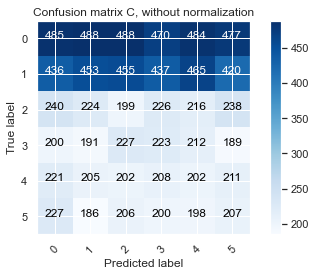

In [ ]:
cm = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5],)
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5],
                      title='Confusion matrix C, without normalization')

***So far we have settled the first portion, construction the histogram matrix.***

## **Step 2: Create the Weighted Matrix w** <a id ="weighted"></a>

An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted rating scores. The formula is as follows:  $$w_{i,j} = \dfrac{(i-j)^2}{(N-1)^2}$$


Under Step-2, each element is weighted. Predictions that are further away from actuals are marked harshly than predictions that are closer to actuals. However, I suddenly realized that these animals above have no obvious hierarchy in them. Therefore, it is not correct to say that predicting a cat as a bird is any better/worse off than predicting a cat as hen.

**Consequently, this is a realization. Because now I start to understand why certain competitions use metrics like quadratic weighted kappa!** Consider the same example as animals just now, but instead of animals, we change to **isup_grade**). So there is an inherent order within the **isup_grade** 0 - 5 such that 0 and 1 is closer than 0 and 2, 1 and 2 is closer to 1 and 3 etc. $$0 > 1 > 2 > 3 > 4 > 5$$

<br>

For example, let's use a simplified example:

    y_true = [2,2,2,1,2,3,4,5,0,1]
    y_pred = [1,2,4,1,2,3,4,5,0,1]
    
As a result, our purpose of the weighted matrix is to allocate a higher penalty score if our prediction is further away from the actual value. That is, if our **isup_grade** is 2 but we predicted it as 1 (see the example), then based on our formula above, we have i = 2 and j = 1 (entry $C_{2,1}$), the penalty is $$\dfrac{(2-1)^2}{(5-1)^2}  = 0.0625$$ but if our **isup_grade** is 2 and we predicted it as 4 (see the example), then the penalty involved is higher $$\dfrac{(2-4)^2}{(5-1)^2} = 0.25$$

Indeed, the weight matrix helped us assign a heavier penalty to predicting 2 as 4 than 2 as 1.

***Lastly, we also observe that the formula will give us 0 for the diagonals of the weighted matrix. This means penalty is 0 whenever we correctly predict something.***

To calculate weighted matrix in python code, here is the code with reference to [Aman Arora](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [ ]:
# We construct the weighted matrix starting from a zero matrix, it is like constructing a 
# list, we usually start from an empty list and add things inside using loops.

def weighted_matrix(N):
    weighted = np.zeros((N,N)) 
    for i in range(len(weighted)):
        for j in range(len(weighted)):
            weighted[i][j] = float(((i-j)**2)/(N-1)**2) 
    return weighted
        
print(weighted_matrix(5))

[[0.   0.06 0.25 0.56 1.  ]
 [0.06 0.   0.06 0.25 0.56]
 [0.25 0.06 0.   0.06 0.25]
 [0.56 0.25 0.06 0.   0.06]
 [1.   0.56 0.25 0.06 0.  ]]


***Remember, the further away from the diagonal you get, the worse off is your prediction and it will be penalized harder by a bigger weight.***  As you can easily infer from the weighted matrix above, we use the first row as an example in case one did not understand. Basically, the weighted matrix's first row's first element is 0, because it means we predicted correctly and no penalty is meted out; but as we move further to the left, you can see that the punishment gets harsher and harsher: $$0 < 0.06 < 0.25 < 0.56 < 1$$

## **Step 3: Create the Expected Matrix** <a id ="expected"></a>

In [ ]:
## dummy example 
actual = pd.Series([2,2,2,3,4,5,5,5,5,5]) 
pred   = pd.Series([2,2,2,3,2,1,1,1,1,3]) 
C = confusion_matrix(actual, pred)

N=5
act_hist=np.zeros([N])
for item in actual: 
    act_hist[item - 1]+=1
    
pred_hist=np.zeros([N])
for item in pred: 
    pred_hist[item - 1]+=1
    

print(f'Actuals value counts:{act_hist}, \nPrediction value counts:{pred_hist}')

Actuals value counts:[0. 3. 1. 1. 5.], 
Prediction value counts:[4. 4. 2. 0. 0.]


This part is the most difficult to understand, especially for someone who has little statistic backgrounds (mind you when I was majoring in applied math back then, I only took **one** statistic module in my whole tenure.) Googling the idea of expected matrix is not apparently clear to me, but luckily someone pointed to me to read expected frequency of Chi-Square test and then and, there I start to slowly understand.

For the purpose of better understanding, we call our actual values to be rater A and our prediction model to be rater B. We want to quantify the agreement between rater A and rater B. Here are some terminologies to get hold of first.

- There are a total number of $k = 5$ classes in this example;
- There are a total number of $n = 10$ observations in this example;
- Define Y to be the random variable that rater A has chosen (aka our actual classes 1,2,3,4,5);
- and $\widehat{Y}$ be the random variable that rater $B$ has chosen (aka our predicted classes 1,2,3,4,5 by rater B)
- $r_i$ be the i-th entry of the column vector for actual value counts shown above, $c_i$ be the i-th entry of the column vector for prediction value counts shown above.
<br>

Then the probability of rater A choosing class 2 and rater B choosing class 2 for example, is given by $$P(Y = 2 \text{ and } \widehat{Y} = 2)  = P(Y = 2) \cdot P(\widehat{Y} = 2) = 30\% \times 40\%  = 12\%$$

This is under the assumption that both raters are **independent of each other**. Note that $P(Y = 2) = 30\%$ because as we see from the actual value counts of rater $A$, there are a total of 3 class 2's and therefore the probability of Y being 2 is just the proportion. Similarly, we calculate $\widehat{Y}$ the same way.

In general, the formula of rater A choosing class i and rater B choosing (predicting) class j is given as follows: $$P(Y = i \text{ and }  \widehat{Y} = j) =  P(Y = i) \times P (\widehat{Y} = j)$$

<br>


Now the real question comes: On average, if you have $n$ number of points to predict, how many times (what is the frequency) would you **expect** to see rater A choose class i and rater B choose class j.

To reiterate, recall that the probability of the actual class being 1 **and (super important word here, it means a joint distribution)** and the predicted class to be 1 as well is $P(Y = 1 \text{ and }  \widehat{Y} = 1)$, similarly, the probability of the actual class being 1 and the predicted class to be 2 is $P(Y = 1 \text{ and }  \widehat{Y} = 2)$. Generalizing, the probability of the actual class being $i$ and the predicted class being $j$ is the joint probability $$P(Y = i \text{ and }  \widehat{Y} = j)$$

So the intuition lies here: based on the joint probability above, what is the expected number of times (frequency) that $Y = i$ and $\widehat{Y} = j$ happened (this means Y is i but rater B predict $\widehat{Y}$ as j) out of 10 times? Easy, just use $n \times P(Y = i \text{ and }  \widehat{Y} = j)$. So for rater B, our prediction model, **by just using theoretical probability**, should have $n \times P(Y = i \text{ and }  \widehat{Y} = j)$ for each $i,j$. But in reality, this may not be the case. Reconcile this idea with the classic coin toss example:

- **Example on coin toss:** Expected frequency is defined as the number of times that we predict an event will occur based on a calculation using theoretical probabilities. You know how a coin has two sides, heads or tails? That means that the probability of the coin landing on any one side is 50% (or 1/2, because it can land on one side out of two possible sides). If you flip a coin 1,000 times, how many times would you expect to get heads? About half the time, or 500 out of the 1,000 flips. To calculate the expected frequency, all we need to do is multiply the total number of tosses (1,000) by the probability of getting a heads (1/2), and we get 1,000 * 1/2 = 500 heads. if event A has prob of p happening, and sample size of n, then the average or expected number of times that A happens is $np$. The expected frequency of heads is 500 out of 1,000 total tosses. The expected frequency is based on our knowledge of probability - we haven't actually done any coin tossing. However, if we had enough time on our hands, we could actually flip a coin 1,000 times to experimentally test our prediction. If we did this, we would be calculating the experimental frequency. The experimental frequency is defined as the number of times that we observe an event to occur when we actually perform an experiment, test, or trial in real life. If you flipped a coin 1,000 times and it landed on heads 479 times, then the experimental frequency of heads is 479.

    But wait - didn't we predict the coin would land on heads 500 times? Why did it actually land on heads only 479 times? Well, the expected frequency was just that - what we expected to happen, based on our knowledge of probability. There are no guarantees when it comes to probability, what we expect to happen might differ from what actually happens. 

<br>

Since we know $$E_{2,2} = 10 \times P(Y = 2 \text{ and } \widehat{Y} = 2)  = 10 \times P(Y = 2) \cdot P(\widehat{Y} = 2) = 10 \times 30\% \times 40\%  = 1.2$$

This $E_{2,2}$ means that we only expect the rater A to choose 2 and rater B to choose 2 at the same time only 1.2 times out of 10 times. In other words, our predicted model classify 2 as 2 1.2 times. However, from our observations in our matrix C (confusion/histogram matrix), rater A choosing 2 and rater B choosing 2 have a frequency of 3! In other words, our predicted model classified 2 as 2 three times! So we kinda exceeded expectation for this particular configuration.

$$C = \begin{bmatrix}
0 & 0 & 0 & 0 & 0\\
0 & 3 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
4 & 0 & 1 & 0 & 0\\
\end{bmatrix}$$

Let me give you one more example, $$E_{5,2} = 10 \times P(Y = 5 \text{ and } \widehat{Y} = 2) = 10 \times P(Y = 5) \cdot P(\widehat{Y} = 2) = 10 \times 50\% \times 40\%  = 2$$

This means that we only expect the rater A to choose 5 and rater B to choose 2 at the same time only 2 times out of 10 times! But in reality, our observations say that our rater B classified 5 as 2 zero times! 


We calculate $E_{i,j}$ given by the formula: $$E_{i,j} = n \times P(Y = i \text{ and }  \widehat{Y} = j) = n \times P(Y = i) \times P (\widehat{Y} = j) = n \times \dfrac{r_i}{n} \times \dfrac{c_j}{n}$$

$$E = \begin{bmatrix}
0 & 0 & 0 & 0 & 0\\
1.2 & 1.2 & 0.6 & 0 & 0 \\
0.4 & 0.4 & 0.2 & 0 & 0\\
0.4 & 0.4 & 0.2 & 0 & 0\\
2 & 2 & 1 & 0 & 0\\
\end{bmatrix}$$

Note $r_i \times c_j$ is the $(i,j)$ entry of the outer product between the actual histogram vector of outcomes (actual value counts) and the predicted histogram vector (prediction value counts).

What does the random chance mean here? Simple, it just means that the probability for rater A (actual) to be class i AND for rater B (predicted) to be class j is $p\%$ (say 10%). Therefore, if we have made 100 predictions, random chance aka the theoratical probability tells us you should only have $100 \times 10\% = 10$ predictions to be of this configuration (rater A class i AND rater B class j).

#### Writing out the expected matrix in python

So to get the expected matrix, E, is calculated assuming that there is no correlation between values.  This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that E and C have the same sum. Note carefully below that we do not need to normalize both, we just need to normalize E to the same sum as C.

In [ ]:
E = np.outer(act_hist, pred_hist)/10


E
C

array([[0. , 0. , 0. , 0. , 0. ],
       [1.2, 1.2, 0.6, 0. , 0. ],
       [0.4, 0.4, 0.2, 0. , 0. ],
       [0.4, 0.4, 0.2, 0. , 0. ],
       [2. , 2. , 1. , 0. , 0. ]])

array([[0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [4, 0, 1, 0, 0]], dtype=int64)

## **Step 4: Final Step: Weighted Kappa formula and Its python codes** <a id="qwk"></a>
 
From these three matrices: E, C and weighted, the quadratic weighted kappa is calculated as: 

$$\kappa = 1 - \dfrac{\sum_{i,j}\text{weighted}_{i,j}C_{i,j}}{\sum_{i,j}\text{weighted}_{i,j}E_{i,j}}$$

Note that a higher value generally means your prediction model is way better than a random model, but there is no consensus on which value is really good or bad.

$$\text{Weighted} = \begin{bmatrix}
0 & 0.0625 & 0.25 & 0.5625 & 1\\
0.0625 & 0 & 0.0625 & 0.25 & 0.5625 \\
0.25 & 0.0625 & 0 & 0.0625 & 0.25\\
0.5625 & 0.25 & 0.0625 & 0 & 0.0625\\
1 & 0.5625 & 0.25 & 0.0625 & 0\\
\end{bmatrix}$$

The notation $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ is just $$\sum_{i=1}^{k}\sum_{j=1}^{k} W_{i,j} C_{i,j} = (W_{1,1}C_{1,1} + W_{1,2}C_{1,2} + ...+ W_{1,k}C_{1,k}) + (W_{2,1}C_{2,1}+...+W_{2,k}C_{2,k}) +...+(W_{k,1}C_{k,1}+...+W_{k,k}C_{k,k})$$

To put our understanding into perspective, consider just one entry $W_{5,1}C_{5,1} = 1 \times 4 = 4$. This roughly means that our predicted model classified class 5 as class 1 FOUR times (re: $C_{5,1} = 4$), and since class 5 is so far away from class 1, we need to **punish** this wrong prediction more than the others. And we did see that the corresponding weight $W_{5,1} = 1$ is the highest weight.

Consequently, the numerator being $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ calculates the total "penalty cost" for the rater A (our predicted model), and similarly, $\sum_{i,j}\text{W}_{i,j}E_{i,j}$ calculates the total "penalty cost" for the rater B (our "expected" model). Therefore, you can think both values (num and den) as a cost function, and the lesser the better. And kappa formula tells us, if our $\sum_{i,j}\text{W}_{i,j}C_{i,j}$ is significantly smaller than $\sum_{i,j}\text{W}_{i,j}E_{i,j}$, this will yield a very small value of $$\dfrac{\sum_{i,j}\text{weighted}_{i,j}C_{i,j}}{\sum_{i,j}\text{weighted}_{i,j}E_{i,j}}$$ which will yield a very high kappa value - signifying a better model.

In [ ]:
# Method 1
# apply the weights to the confusion matrix
weighted = weighted_matrix(5)
num = np.sum(np.multiply(weighted, C))
# apply the weights to the histograms
den = np.sum(np.multiply(weighted, E))

kappa = 1-np.divide(num,den)
kappa

-0.13924050632911378

In [ ]:
# Method 2

num=0
den=0
for i in range(len(weighted)):
    for j in range(len(weighted)):
        num+=weighted[i][j]*C[i][j]
        den+=weighted[i][j]*E[i][j]

weighted_kappa = (1 - (num/den)); weighted_kappa

-0.13924050632911378

In [ ]:
# Method 3: Just use sk learn library

cohen_kappa_score(actual, pred, labels=None, weights= 'quadratic', sample_weight=None)

-0.13924050632911378

Just a side note that one can also use SK learn's cohen_kappa_score function calculate the quadratic weighted kappa in this competition, with weights set to quadratic. Also please do refer to [CPMP's discussion topic for fast QWK computation](https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/145105)